In [6]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

In [7]:
#Load the data
extension = "cp"
print(f"-------------------------------- Load M {extension} --------------------------------")
name_experiment = "playground_metropolis_" + extension
path_start = "./outputs/" + name_experiment + "/"
lst_data = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load M cp --------------------------------
Loaded: ./outputs/playground_metropolis_cp/2024-09-12/22-09-12_442/all.json
Loaded: ./outputs/playground_metropolis_cp/2024-09-12/22-10-25_443/all.json


In [8]:
# Reconstruct all rules M
all_rules = []
all_likelihoods = []
all_weights = []
all_prev_rules_ind = []
for data in lst_data:
    nb_particles = data["metrics"]["nb_rules"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["metrics"]["test_likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules = np.concatenate(all_rules, axis=0)
all_likelihoods = np.concatenate(all_likelihoods, axis=0)
all_weights = np.concatenate(all_weights, axis=0)
all_prev_rules_ind = np.concatenate(all_prev_rules_ind, axis=0)

# Print rules

In [9]:
# Compare best rule for Metropolis
# Best rules for each seed
best_taken = 1000
best_rules_ind_seed = np.argsort(-all_likelihoods, axis=1)[:,:best_taken]
best_rules = np.take_along_axis(all_rules, best_rules_ind_seed, axis=1)
best_likelihoods = np.take_along_axis(all_likelihoods, best_rules_ind_seed, axis=1)
best_rules_ind = np.argsort(-best_likelihoods.flatten())
for incr, ind in enumerate(best_rules_ind):
    seed = ind % all_rules.shape[0]
    unravel_ind = np.unravel_index(ind, best_rules.shape)
    print(
        f"-----rule-----:{incr}({seed}): {repr(best_rules[unravel_ind])}, likelihood: {best_likelihoods[unravel_ind]:2f}"
    )

-----rule-----:0(3): 'Rule 07: A water and beet seed transform into the beet.\nRule 08: A water and berry seed transform into the berry.\nRule 09: A water and carrot seed transform into the carrot.\nRule 10: A beet, carrot, and baby elephant transform into the elephant.\nRule 11: The carrot, berry, and baby elephant transform into the elephant.\n', likelihood: -175.844589
-----rule-----:1(4): 'Based on your provided sequence of actions and observations, I deduce the following rules:\n\nRule 01: Water alone does not transform or change.\nRule 02: Water and berry seed transform into the berry.\nRule 03: Water and pea seed transform into the pea.\nRule 04: Water and carrot seed transform into the carrot.\nRule 05: Water and other seeds (beet, potato) do not transform into seeds when exposed.\nRule 06: Potential berries, when placed on each other, transform into that one type of berry.\nRule 07: Large herbivores cannot transform into these specific herbivores.\nRule 08: The pig and the bab

# Individual Analysis

## Metropolis analysis


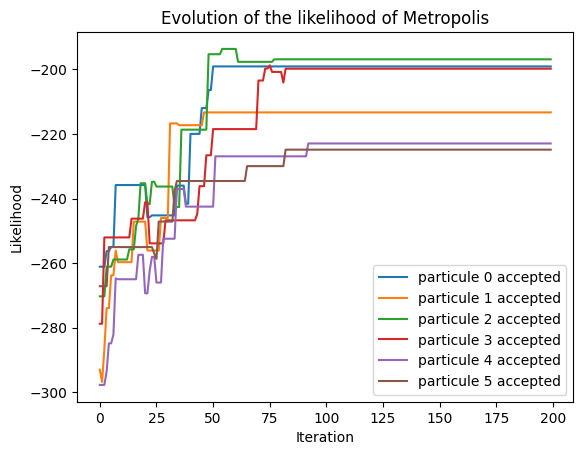

In [10]:
plt.figure()
for seed in range(all_rules.shape[0]):
    plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis")
plt.show()


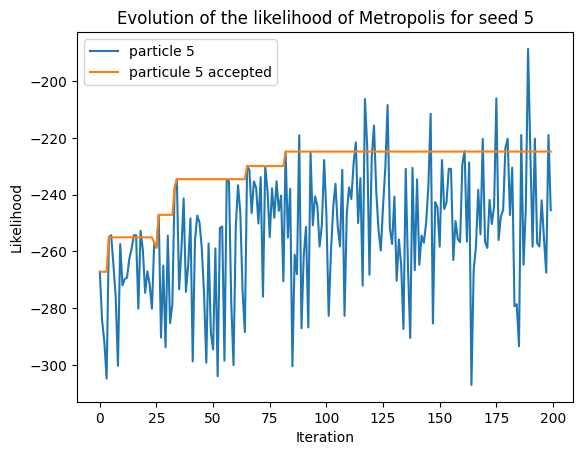

In [12]:
seed = 5
plt.figure()
plt.plot(all_likelihoods[seed, :-1], label="particle "+ str(seed))
plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis for seed " + str(seed))
plt.show()


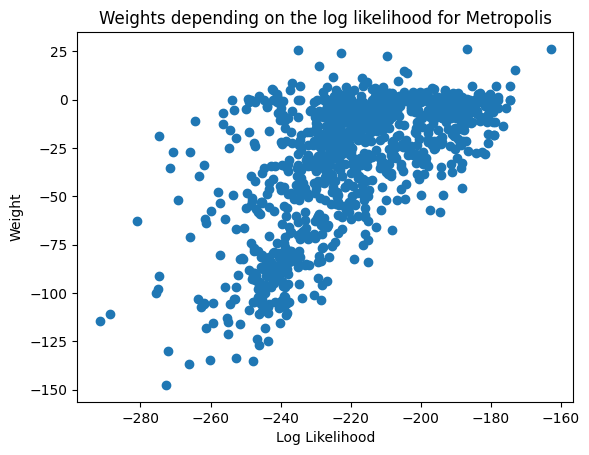

In [7]:
# Evolution of the weights depending on the likelihood
plt.figure()
plt.scatter(all_likelihoods.flatten(), all_weights.flatten())
plt.xlabel("Log Likelihood")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood for Metropolis")
plt.show()


Text(0.5, 1.0, 'Weights depending on the log likelihood difference')

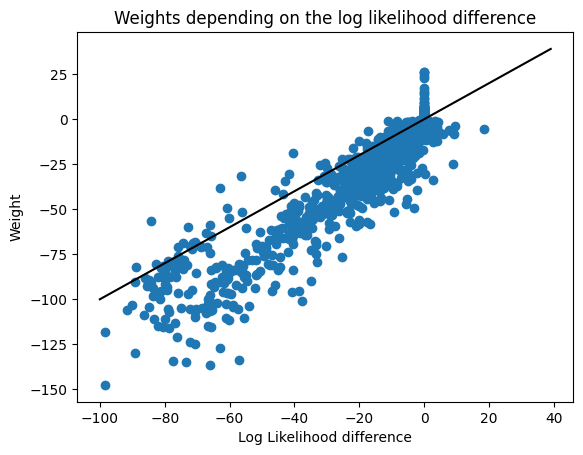

In [8]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood difference")

Text(0.5, 1.0, 'Difference of weights depending on the log likelihood difference')

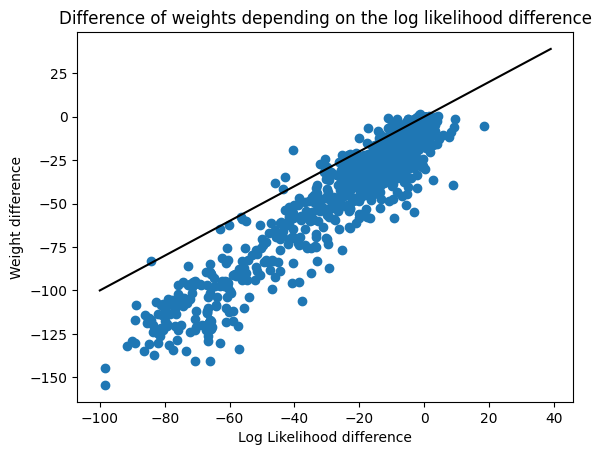

In [9]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1] - all_weights[_index, all_prev_rules_ind[:,1:]])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight difference")
plt.title("Difference of weights depending on the log likelihood difference")

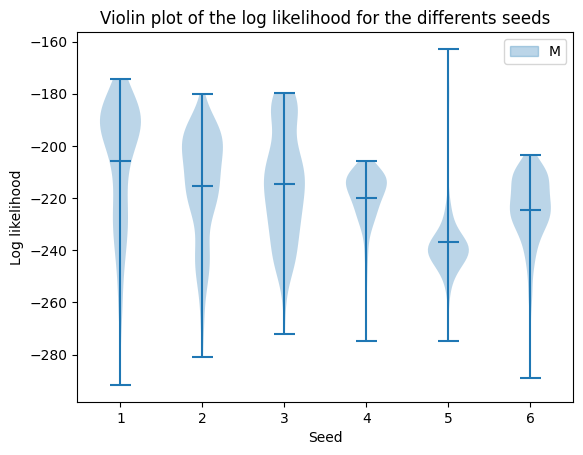

In [10]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_m = plt.violinplot(all_likelihoods.transpose(), showmeans=True)["bodies"][0].get_facecolor().flatten()
color_m = matplotlib.patches.Patch(color=color_m)
plt.legend([color_m], ["M"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()